# RSNA 2025 Intracranial Aneurysm Detection - Result Analysis

This notebook performs comprehensive cross-fold analysis of misclassifications from the 5-fold CV training using a modular engine-based architecture.

## Architecture
- **InferenceEngine**: Handles data loading, model loading, and prediction collection
- **AnalysisEngine**: Performs misclassification analysis and hard sample identification
- **VisualizationEngine**: Creates comprehensive visualizations and plots

## Analysis Framework
- **Out-of-Fold (OOF) Predictions**: Uses true OOF predictions for each sample (no data leakage)
- **Per-Class Analysis**: Detailed misclassification analysis for each of the 14 classes
- **Hard Sample Identification**: Identifies different types of challenging cases

## Key Features
- Modular, separated engine architecture
- Comprehensive misclassification analysis
- Per-class error breakdown
- Hard sample case studies
- Interactive visualizations
- Actionable insights for model improvement


In [1]:
# Import required libraries
import os
import sys
import json
import pickle
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch
import torch.nn as nn
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score
)
from tqdm import tqdm
import cv2

# Add project root to path
sys.path.append('..')
from train import HybridAneurysmModel, Config
from utils import LABEL_COLS, ID_COL, load_cached_volume, take_window, valid_coords
from analysis import InferenceEngine, AnalysisEngine, VisualizationEngine

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


/home/reasat/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration and Setup


In [2]:
# Configuration
EXPERIMENT_DIR = "models/2025-09-11-20-34-47"
NUM_FOLDS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load experiment configuration
with open(f"{EXPERIMENT_DIR}/used_config.yaml", 'r') as f:
    import yaml
    config_dict = yaml.safe_load(f)

# Create Config object
path = f"configs/train_config.yaml"
config = Config(path) # load default config

# override with experiment config
config.architecture = config_dict['model']['architecture']
config.img_size = config_dict['data']['img_size']
config.window_offsets = config_dict['data']['window_offsets']
config.roi_box_fraction = config_dict['data']['roi_box_fraction']
config.cache_dir = config_dict['paths']['cache_dir']
config.device = DEVICE

print(f"Experiment: {EXPERIMENT_DIR}")
print(f"Architecture: {config.architecture}")
print(f"Image size: {config.img_size}")
print(f"Device: {DEVICE}")


📄 Loading configuration from: configs/train_config.yaml
✅ Configuration loaded successfully
Experiment: models/2025-09-11-20-34-47
Architecture: tf_efficientnet_b0
Image size: 224
Device: cuda


## 🔧 Inference Engine Execution

The following section handles data loading, model loading, and prediction collection using the InferenceEngine.


## Main Execution


In [4]:
# Initialize engines (now imported from analysis.py)
inference_engine = InferenceEngine(EXPERIMENT_DIR, config)
analysis_engine = AnalysisEngine(inference_engine)
visualization_engine = VisualizationEngine(inference_engine)

# Load fold assignments
train_csv_path = config_dict['paths']['train_csv']
inference_engine.load_fold_assignments(train_csv_path)

# Load models
inference_engine.load_fold_models()

# Get sample IDs for analysis (use a subset for testing)
all_sample_ids = list(inference_engine.fold_assignments.keys())
print(f"Total samples available: {len(all_sample_ids)}")

# For testing, use a subset (remove this for full analysis)
test_sample_ids = np.random.RandomState(42).choice(all_sample_ids, size=1000, replace=False).tolist()
print(f"Using {len(test_sample_ids)} samples for analysis")


Filtered to modalities: CTA, MRA, MRI T2, MRI T1post
Recreated fold assignments for 4348 samples
Fold distribution: {0: 870, 1: 870, 2: 870, 3: 869, 4: 869}
Modality distribution: {'CTA': 1808, 'MRA': 1252, 'MRI T2': 983, 'MRI T1post': 305}
Loaded fold 0 model
Loaded fold 1 model
Loaded fold 2 model
Loaded fold 3 model
Loaded fold 4 model
Total samples available: 4348
Using 1000 samples for analysis


In [18]:
# Collect OOF predictions
inference_engine.collect_oof_predictions(test_sample_ids)

print(f"Collected OOF predictions for {len(inference_engine.oof_predictions)} samples")
print(f"Average predictions per sample: {np.mean([len(preds) for preds in inference_engine.oof_predictions.values()]):.1f}")

# Load true labels for analysis
true_labels_df = pd.read_csv(train_csv_path)
print(f"Loaded true labels for {len(true_labels_df)} samples")


  6%|▌         | 62/1000 [01:02<15:40,  1.00s/it]


KeyboardInterrupt: 

## 📊 Analysis Engine Execution

The following section uses the AnalysisEngine to perform misclassification analysis and identify hard samples.


In [6]:
# Run comprehensive analysis
print("🔍 Starting Cross-Fold Analysis...")

# 1. Per-class misclassification analysis
print("📊 Analyzing per-class misclassifications...")
per_class_analysis = analysis_engine.analyze_per_class_misclassifications(true_labels_df)

# 2. Hard sample identification
print("🎯 Identifying hard samples...")
hard_samples = analysis_engine.identify_hard_samples(true_labels_df)

print("✅ Analysis complete!")


🔍 Starting Cross-Fold Analysis...
📊 Analyzing per-class misclassifications...
🎯 Identifying hard samples...
✅ Analysis complete!


In [21]:
for i, class_name in enumerate(per_class_analysis.keys()):
    print(f"idx: {i}, {class_name}")

idx: 0, Left Infraclinoid Internal Carotid Artery
idx: 1, Right Infraclinoid Internal Carotid Artery
idx: 2, Left Supraclinoid Internal Carotid Artery
idx: 3, Right Supraclinoid Internal Carotid Artery
idx: 4, Left Middle Cerebral Artery
idx: 5, Right Middle Cerebral Artery
idx: 6, Anterior Communicating Artery
idx: 7, Left Anterior Cerebral Artery
idx: 8, Right Anterior Cerebral Artery
idx: 9, Left Posterior Communicating Artery
idx: 10, Right Posterior Communicating Artery
idx: 11, Basilar Tip
idx: 12, Other Posterior Circulation
idx: 13, Aneurysm Present


## 📈 Visualization Engine Execution

The following section uses the VisualizationEngine to create comprehensive visualizations of the analysis results.


📈 Creating visualizations...


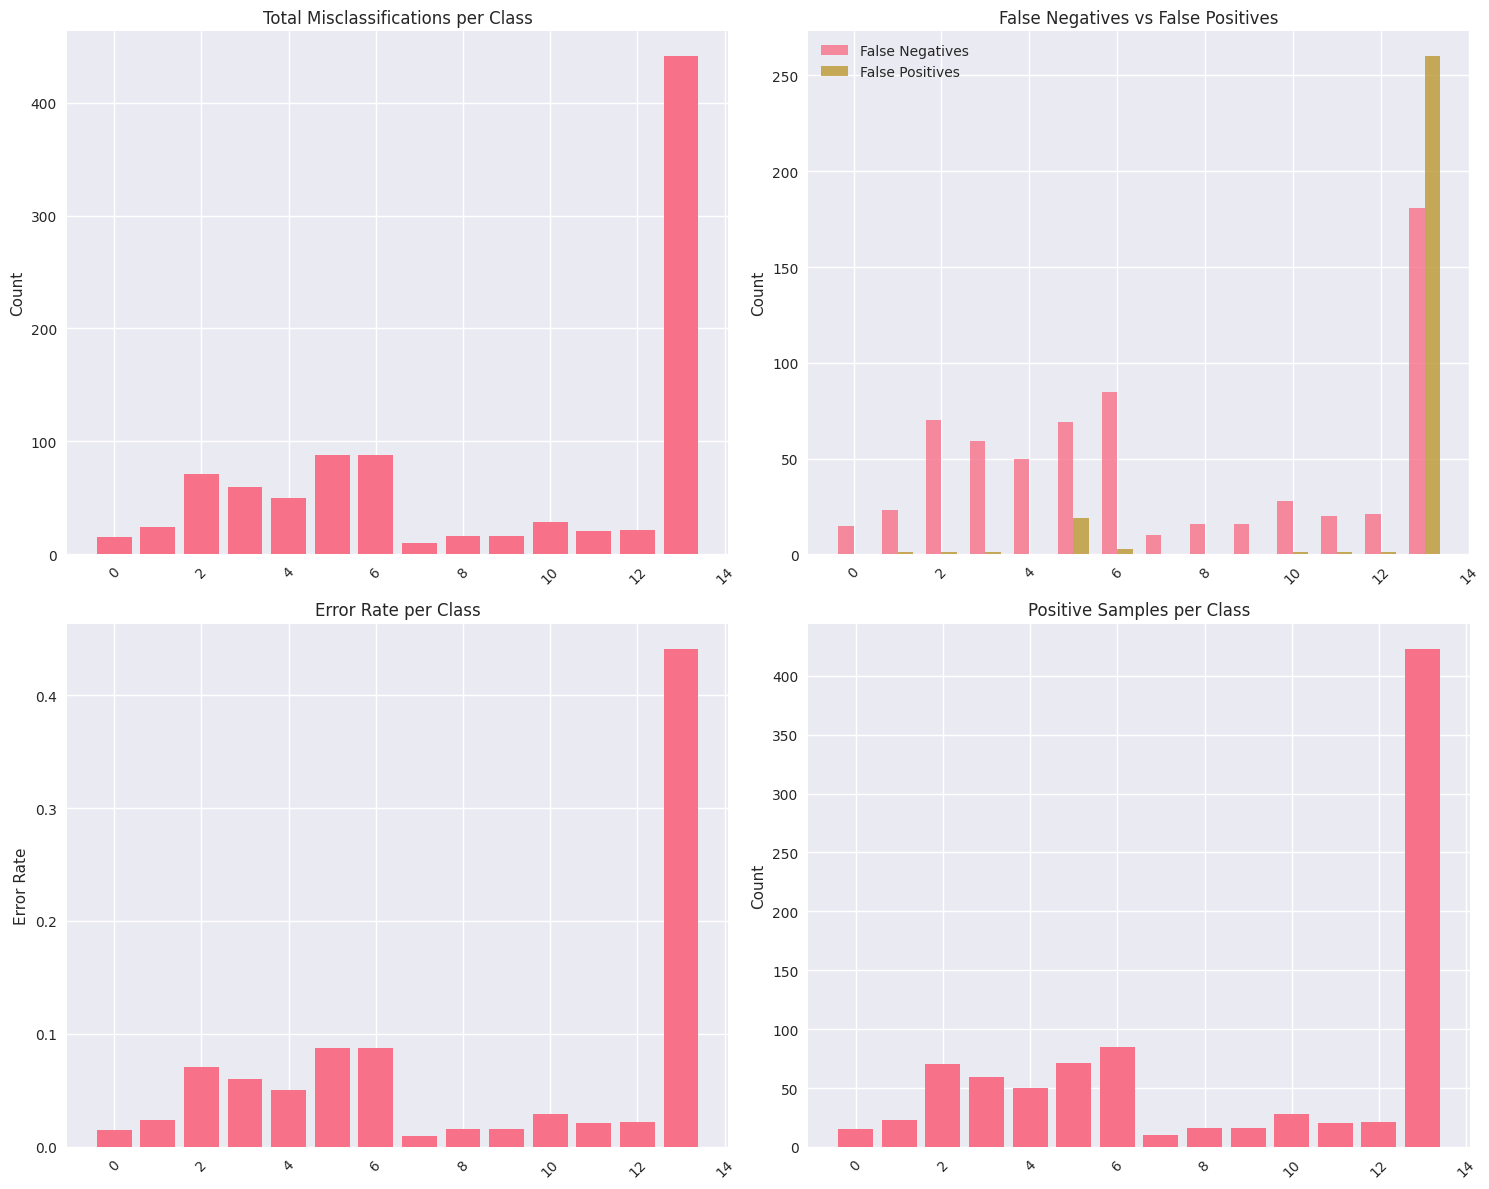

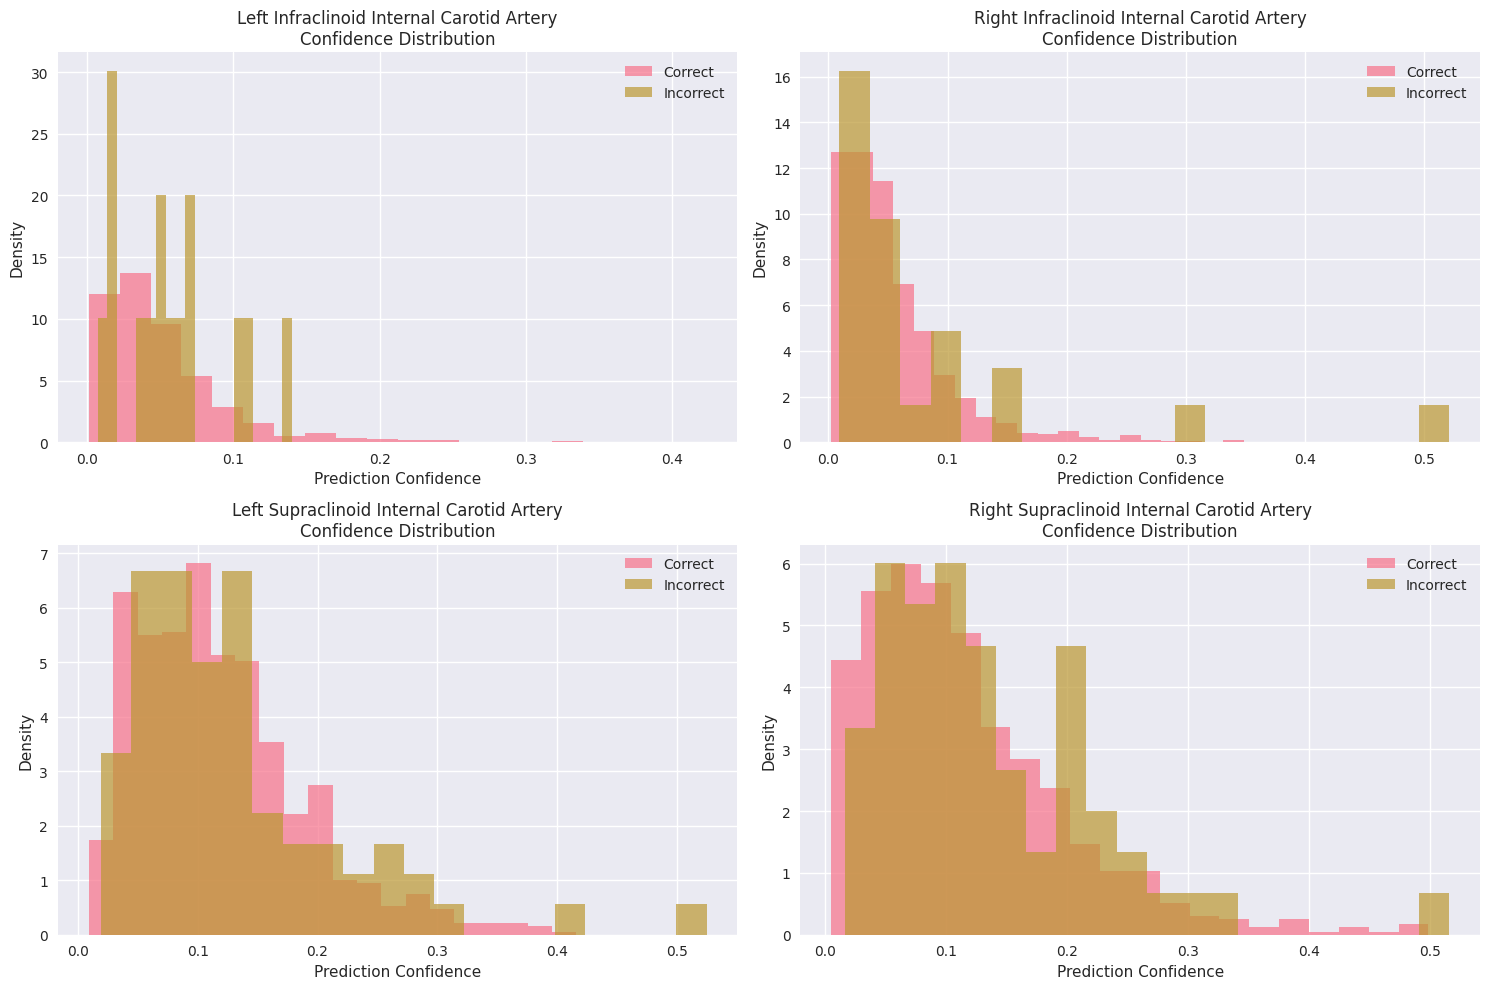

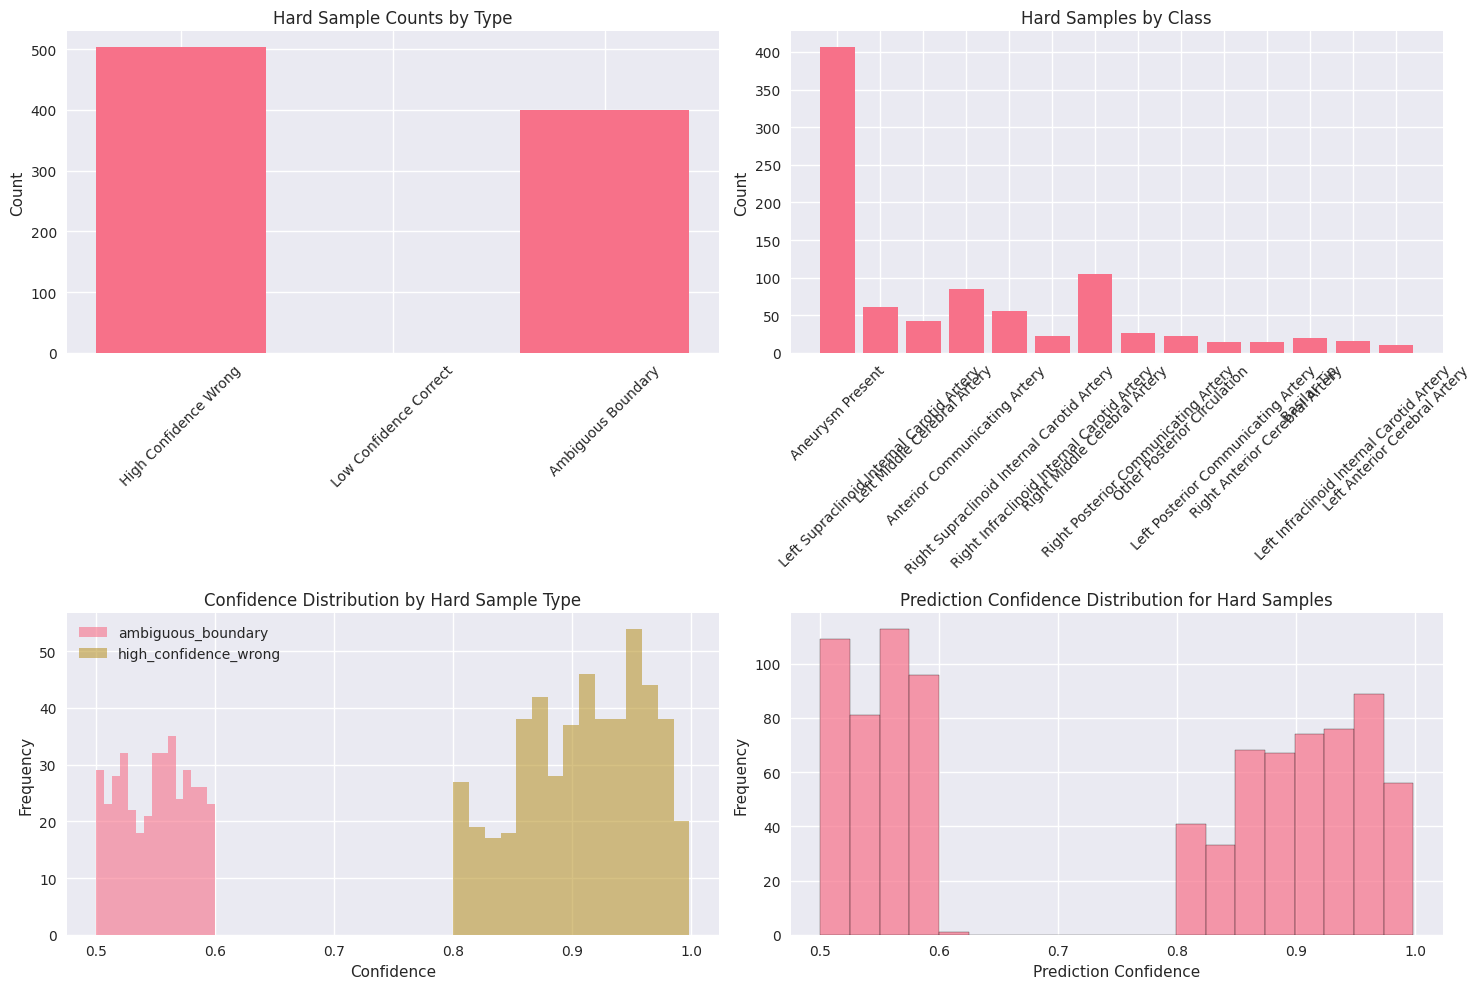

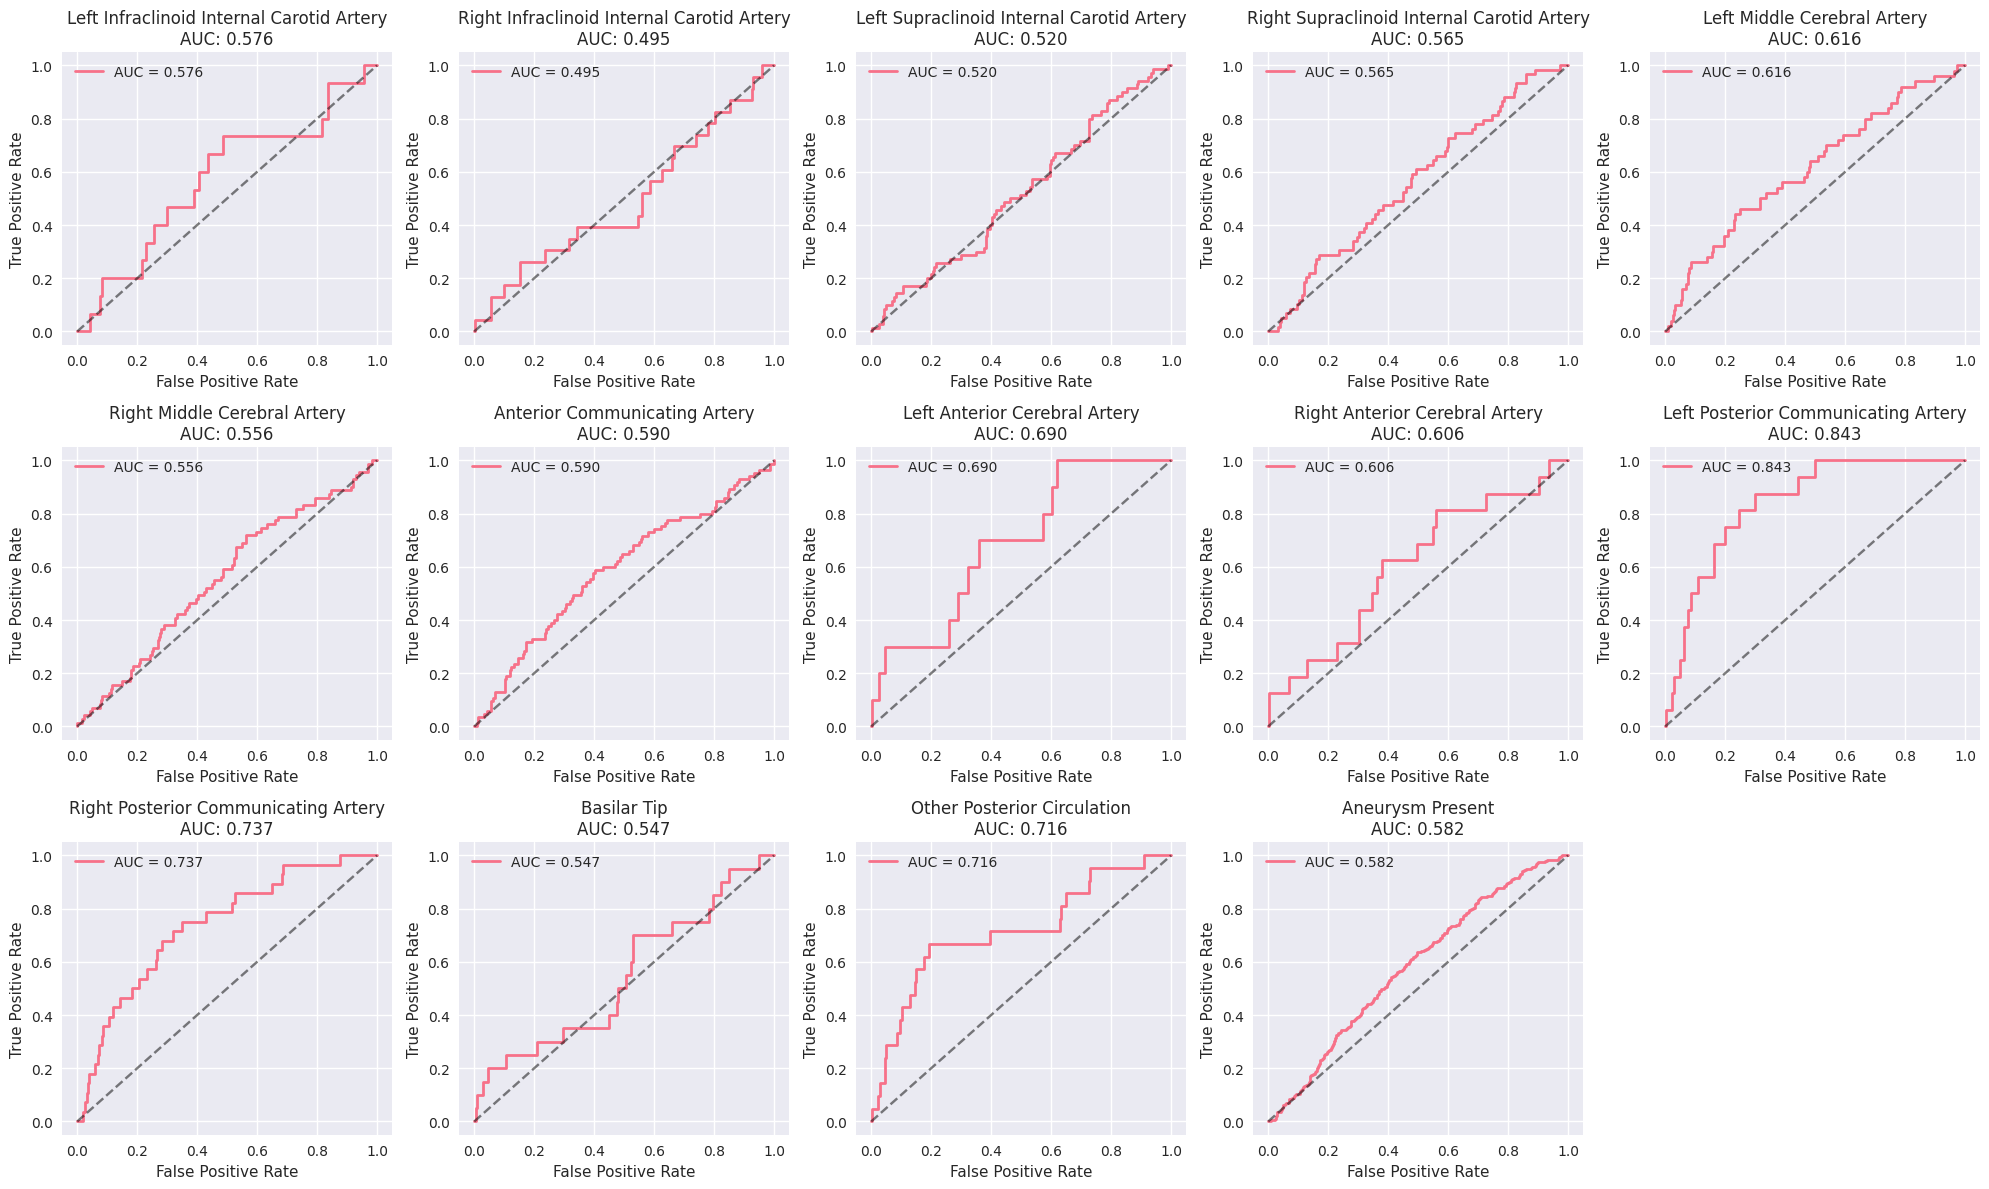

In [7]:
# Generate visualizations
# (Moved print statement inside for clarity)
print("📈 Creating visualizations...")
visualization_engine.create_visualizations(per_class_analysis, hard_samples, true_labels_df)

## Results Summary


In [8]:
# Print comprehensive results summary
print("=" * 80)
print("📋 CROSS-FOLD ANALYSIS RESULTS SUMMARY")
print("=" * 80)

# Overall statistics
total_samples = len(inference_engine.oof_predictions)
print(f"\\n📊 Overall Statistics:")
print(f"  • Total samples analyzed: {total_samples}")
print(f"  • Average OOF predictions per sample: {np.mean([len(preds) for preds in inference_engine.oof_predictions.values()]):.1f}")

# Per-class summary
print(f"\\n🎯 Per-Class Misclassification Summary:")
for class_name, analysis in per_class_analysis.items():
    fn_count = len(analysis['false_negatives'])
    fp_count = len(analysis['false_positives'])
    total_errors = fn_count + fp_count
    error_rate = total_errors / analysis['total_samples'] if analysis['total_samples'] > 0 else 0
    
    print(f"  • {class_name}:")
    print(f"    - Total samples: {analysis['total_samples']}")
    print(f"    - Positive samples: {analysis['positive_samples']}")
    print(f"    - False Negatives: {fn_count}")
    print(f"    - False Positives: {fp_count}")
    print(f"    - Error Rate: {error_rate:.3f}")

# Hard samples summary
print(f"\\n🎯 Hard Sample Summary:")
for hard_type, samples in hard_samples.items():
    print(f"  • {hard_type}: {len(samples)} samples")

print("\\n" + "=" * 80)
print("✅ Analysis Complete! Check visualizations above for detailed insights.")
print("=" * 80)


📋 CROSS-FOLD ANALYSIS RESULTS SUMMARY
\n📊 Overall Statistics:
  • Total samples analyzed: 1000
  • Average OOF predictions per sample: 14.0
\n🎯 Per-Class Misclassification Summary:
  • Left Infraclinoid Internal Carotid Artery:
    - Total samples: 1000
    - Positive samples: 15
    - False Negatives: 15
    - False Positives: 0
    - Error Rate: 0.015
  • Right Infraclinoid Internal Carotid Artery:
    - Total samples: 1000
    - Positive samples: 23
    - False Negatives: 23
    - False Positives: 1
    - Error Rate: 0.024
  • Left Supraclinoid Internal Carotid Artery:
    - Total samples: 1000
    - Positive samples: 70
    - False Negatives: 70
    - False Positives: 1
    - Error Rate: 0.071
  • Right Supraclinoid Internal Carotid Artery:
    - Total samples: 1000
    - Positive samples: 59
    - False Negatives: 59
    - False Positives: 1
    - Error Rate: 0.060
  • Left Middle Cerebral Artery:
    - Total samples: 1000
    - Positive samples: 50
    - False Negatives: 50
    -

## 🔬 4-Modality Analysis

This section demonstrates the new 4-modality analysis capability:
- **CTA** (CT Angiography)
- **MRA** (MR Angiography) 
- **MRI T2** (T2-weighted MRI)
- **MRI T1post** (T1-weighted post-contrast MRI)

The analysis extracts modality information from CSV and performs comprehensive 4-way comparisons.


In [9]:
# Extract modality mapping for 4-modality analysis
from analysis import extract_modality_mapping

# Get sample IDs that have predictions
sample_ids = list(inference_engine.oof_predictions.keys())
print(f"Analyzing {len(sample_ids)} samples with predictions")

# Extract modality mapping from CSV
modality_mapping = extract_modality_mapping(sample_ids, train_csv_path)

# Show the 4-modality distribution
print(f"\n4-Modality Distribution:")
for modality, count in sorted(modality_mapping.items(), key=lambda x: x[1], reverse=True):
    print(f"  {modality}: {count} samples")


Analyzing 1000 samples with predictions
Extracted modality mapping for 1000 samples
Modality distribution: {'CTA': 422, 'MRI T2': 224, 'MRA': 281, 'MRI T1post': 73}

4-Modality Distribution:
  1.2.826.0.1.3680043.8.498.88339634554367053656742978297774730360: MRI T2 samples
  1.2.826.0.1.3680043.8.498.12768843892616555302989444677286558651: MRI T2 samples
  1.2.826.0.1.3680043.8.498.69605291784145811885469799991068411138: MRI T2 samples
  1.2.826.0.1.3680043.8.498.10288848585792562273752173975279351795: MRI T2 samples
  1.2.826.0.1.3680043.8.498.53863103480136362800851232400573105038: MRI T2 samples
  1.2.826.0.1.3680043.8.498.88323263730083616451529182204674106561: MRI T2 samples
  1.2.826.0.1.3680043.8.498.77710080228621144369590367259303137264: MRI T2 samples
  1.2.826.0.1.3680043.8.498.96526563947153487181348209853316718497: MRI T2 samples
  1.2.826.0.1.3680043.8.498.12393407174741113415167024081413413015: MRI T2 samples
  1.2.826.0.1.3680043.8.498.3563345089666185417964020021268365

In [10]:
# Run 4-modality analysis
print("🔬 Starting 4-Modality Analysis...")

# 1. Modality-specific performance analysis
print("📊 Analyzing performance across 4 modalities...")
modality_analysis = analysis_engine.analyze_modality_performance(
    true_labels_df, 
    sample_modalities=modality_mapping
)

# 2. Modality-specific hard sample identification
print("🎯 Identifying modality-specific hard samples...")
modality_hard_samples = analysis_engine.identify_modality_hard_samples(
    true_labels_df,
    sample_modalities=modality_mapping
)

print("✅ 4-Modality analysis complete!")


🔬 Starting 4-Modality Analysis...
📊 Analyzing performance across 4 modalities...
🎯 Identifying modality-specific hard samples...
✅ 4-Modality analysis complete!


In [11]:
# Print 4-modality performance summary
print("=" * 80)
print("📋 4-MODALITY ANALYSIS RESULTS SUMMARY")
print("=" * 80)

for modality, analysis in modality_analysis.items():
    total_samples = analysis['total_samples']
    aneurysm_samples = analysis['aneurysm_present_samples']
    auc = analysis['overall_metrics'].get('auc', 0.0)
    
    print(f"\n🔬 {modality}:")
    print(f"  • Total samples: {total_samples}")
    print(f"  • Aneurysm present: {aneurysm_samples} ({aneurysm_samples/total_samples*100:.1f}%)")
    print(f"  • Overall AUC: {auc:.3f}")
    
    # Show per-class performance for top classes
    class_performance = []
    for class_name, class_analysis in analysis['per_class_analysis'].items():
        if class_analysis['total_samples'] > 0:
            f1 = class_analysis.get('f1_score', 0.0)
            class_performance.append((class_name, f1))
    
    # Sort by F1 score and show top 3
    class_performance.sort(key=lambda x: x[1], reverse=True)
    print(f"  • Top performing classes:")
    for class_name, f1 in class_performance[:3]:
        print(f"    - {class_name}: F1={f1:.3f}")

print("\n" + "=" * 80)


📋 4-MODALITY ANALYSIS RESULTS SUMMARY

🔬 MRI T1post:
  • Total samples: 73
  • Aneurysm present: 18 (24.7%)
  • Overall AUC: 0.812
  • Top performing classes:
    - Basilar Tip: F1=1.973
    - Left Middle Cerebral Artery: F1=1.945
    - Right Infraclinoid Internal Carotid Artery: F1=1.918

🔬 CTA:
  • Total samples: 422
  • Aneurysm present: 230 (54.5%)
  • Overall AUC: 0.793
  • Top performing classes:
    - Left Anterior Cerebral Artery: F1=1.962
    - Left Infraclinoid Internal Carotid Artery: F1=1.953
    - Right Infraclinoid Internal Carotid Artery: F1=1.953

🔬 MRA:
  • Total samples: 281
  • Aneurysm present: 120 (42.7%)
  • Overall AUC: 0.804
  • Top performing classes:
    - Left Anterior Cerebral Artery: F1=1.986
    - Right Anterior Cerebral Artery: F1=1.986
    - Left Posterior Communicating Artery: F1=1.986

🔬 MRI T2:
  • Total samples: 224
  • Aneurysm present: 55 (24.6%)
  • Overall AUC: 0.785
  • Top performing classes:
    - Left Infraclinoid Internal Carotid Artery: F1=

📈 Creating 4-modality visualizations...


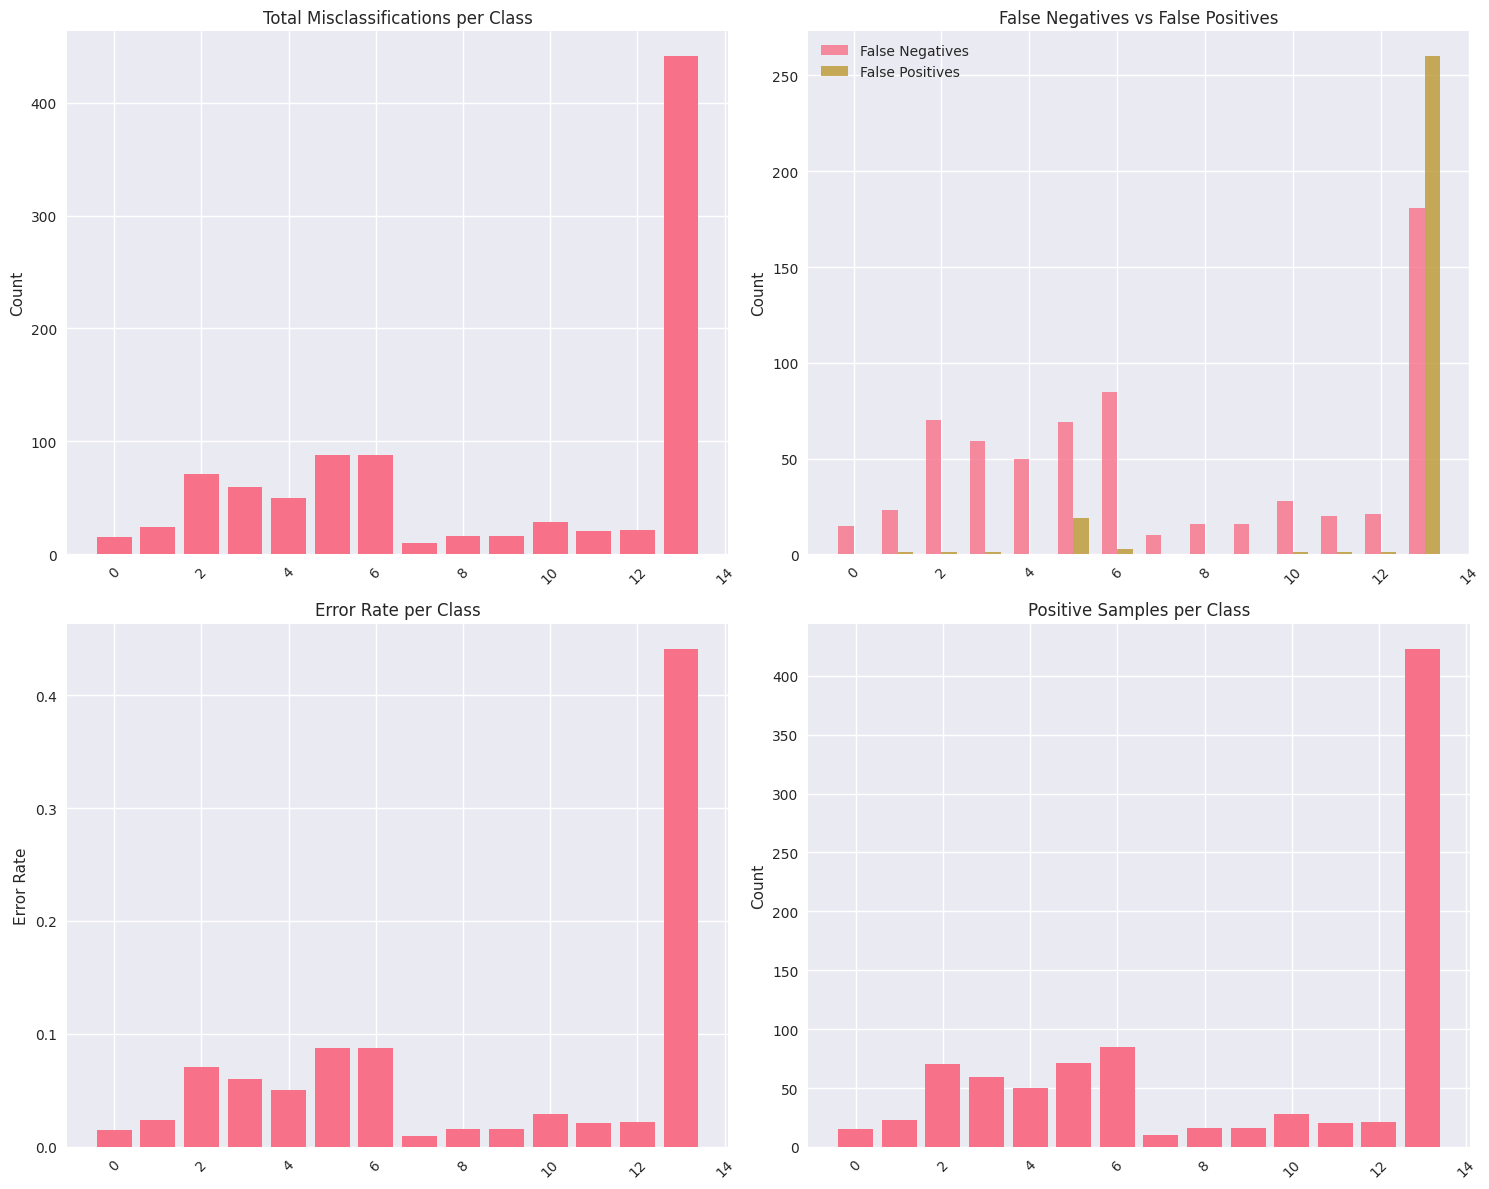

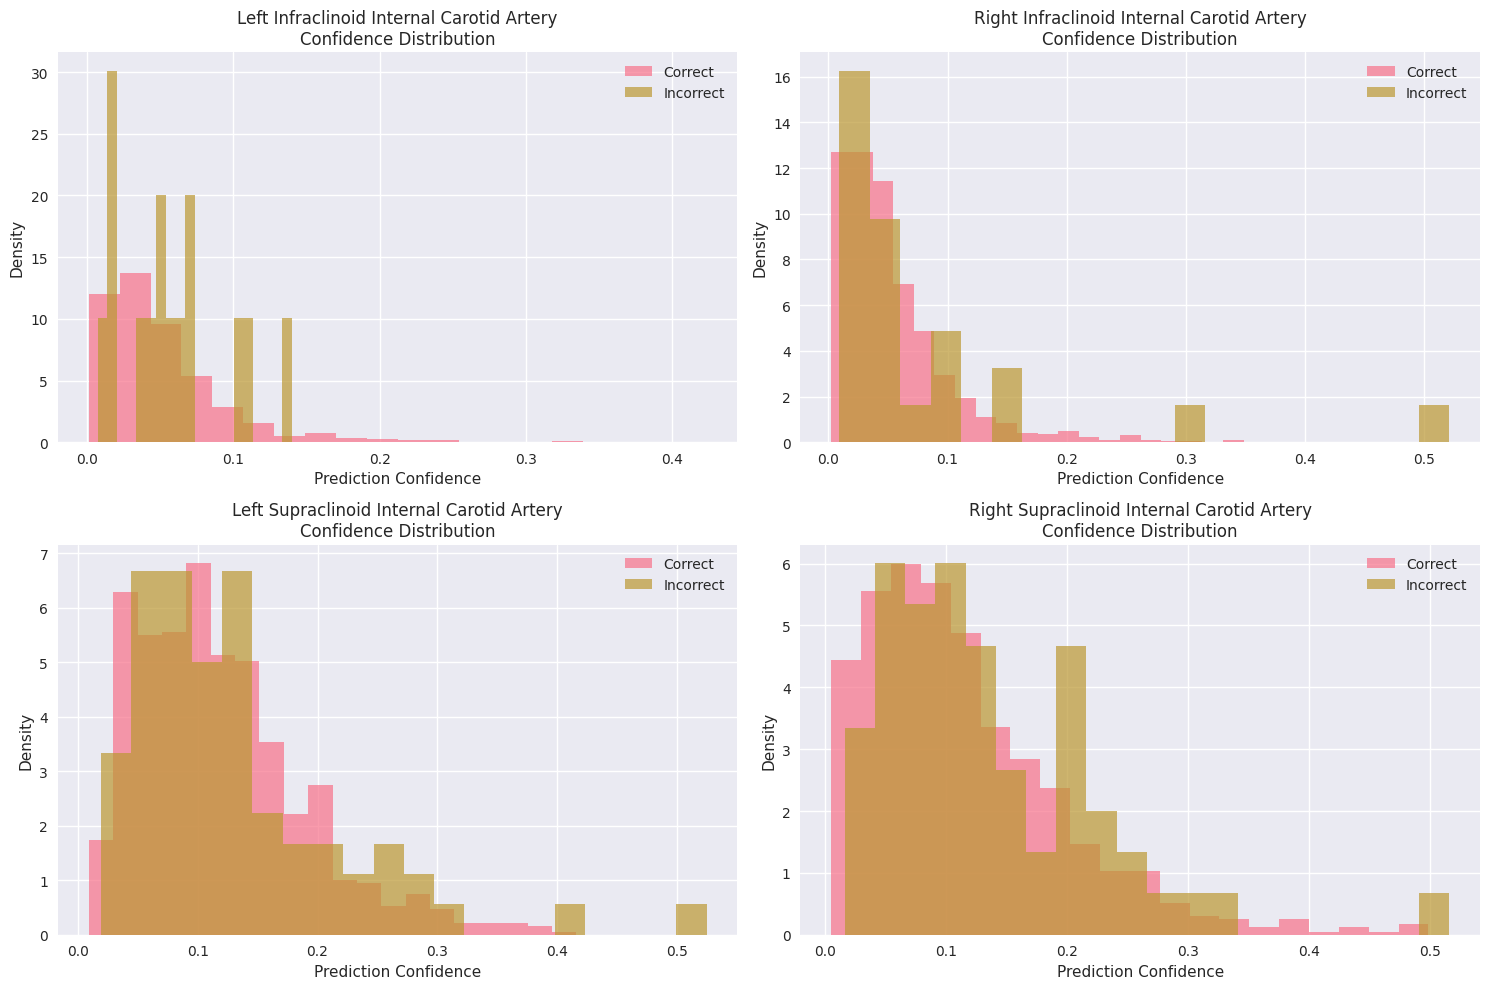

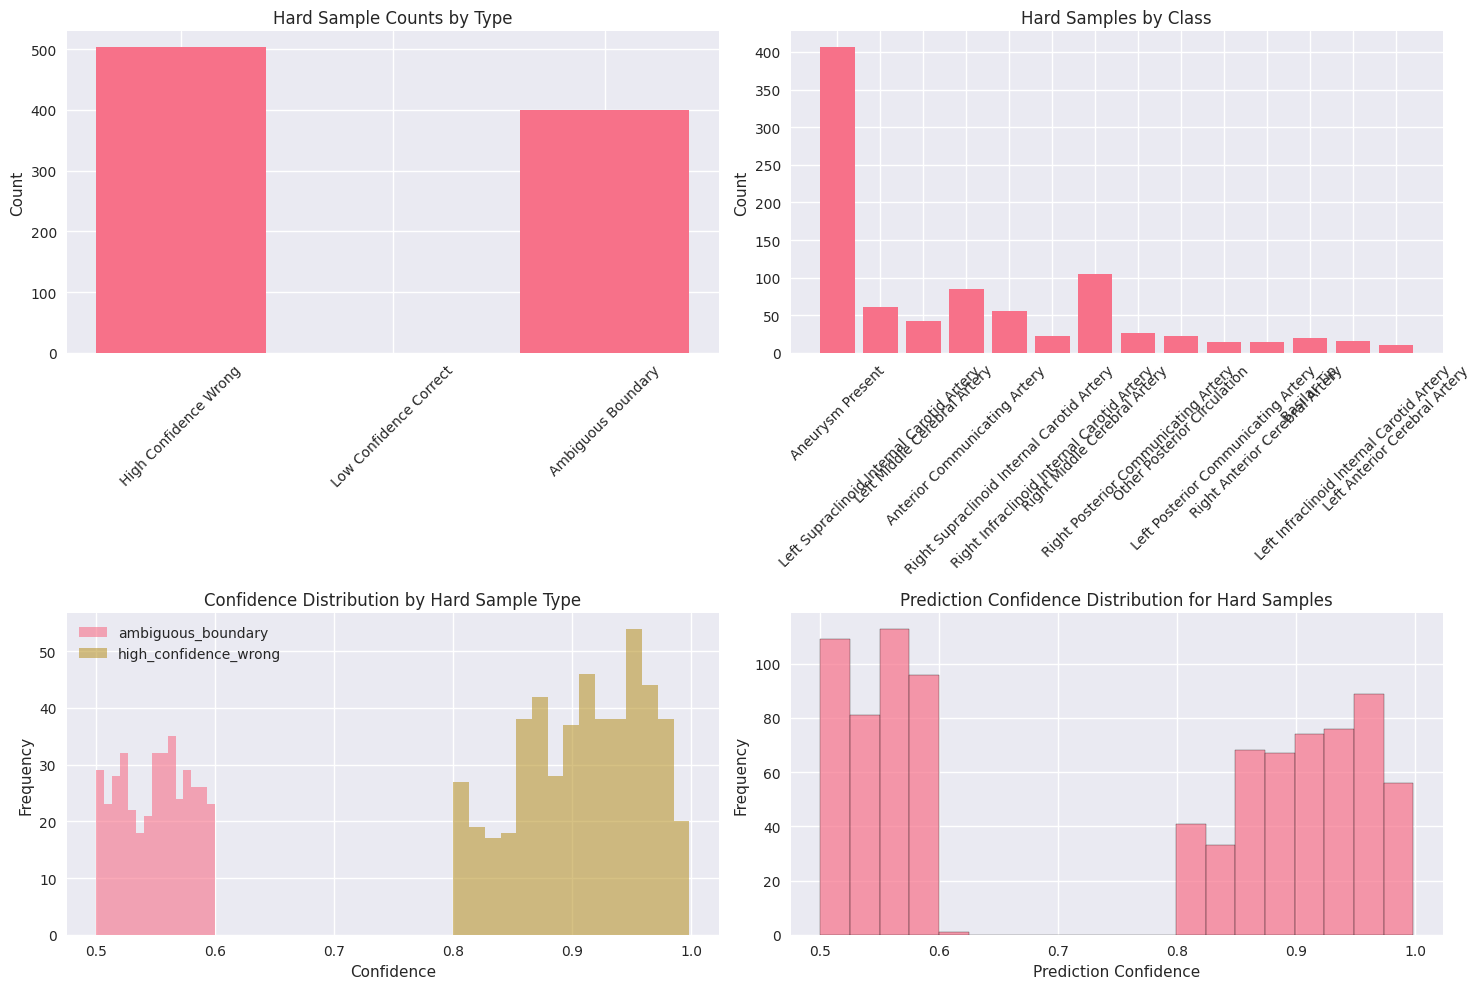

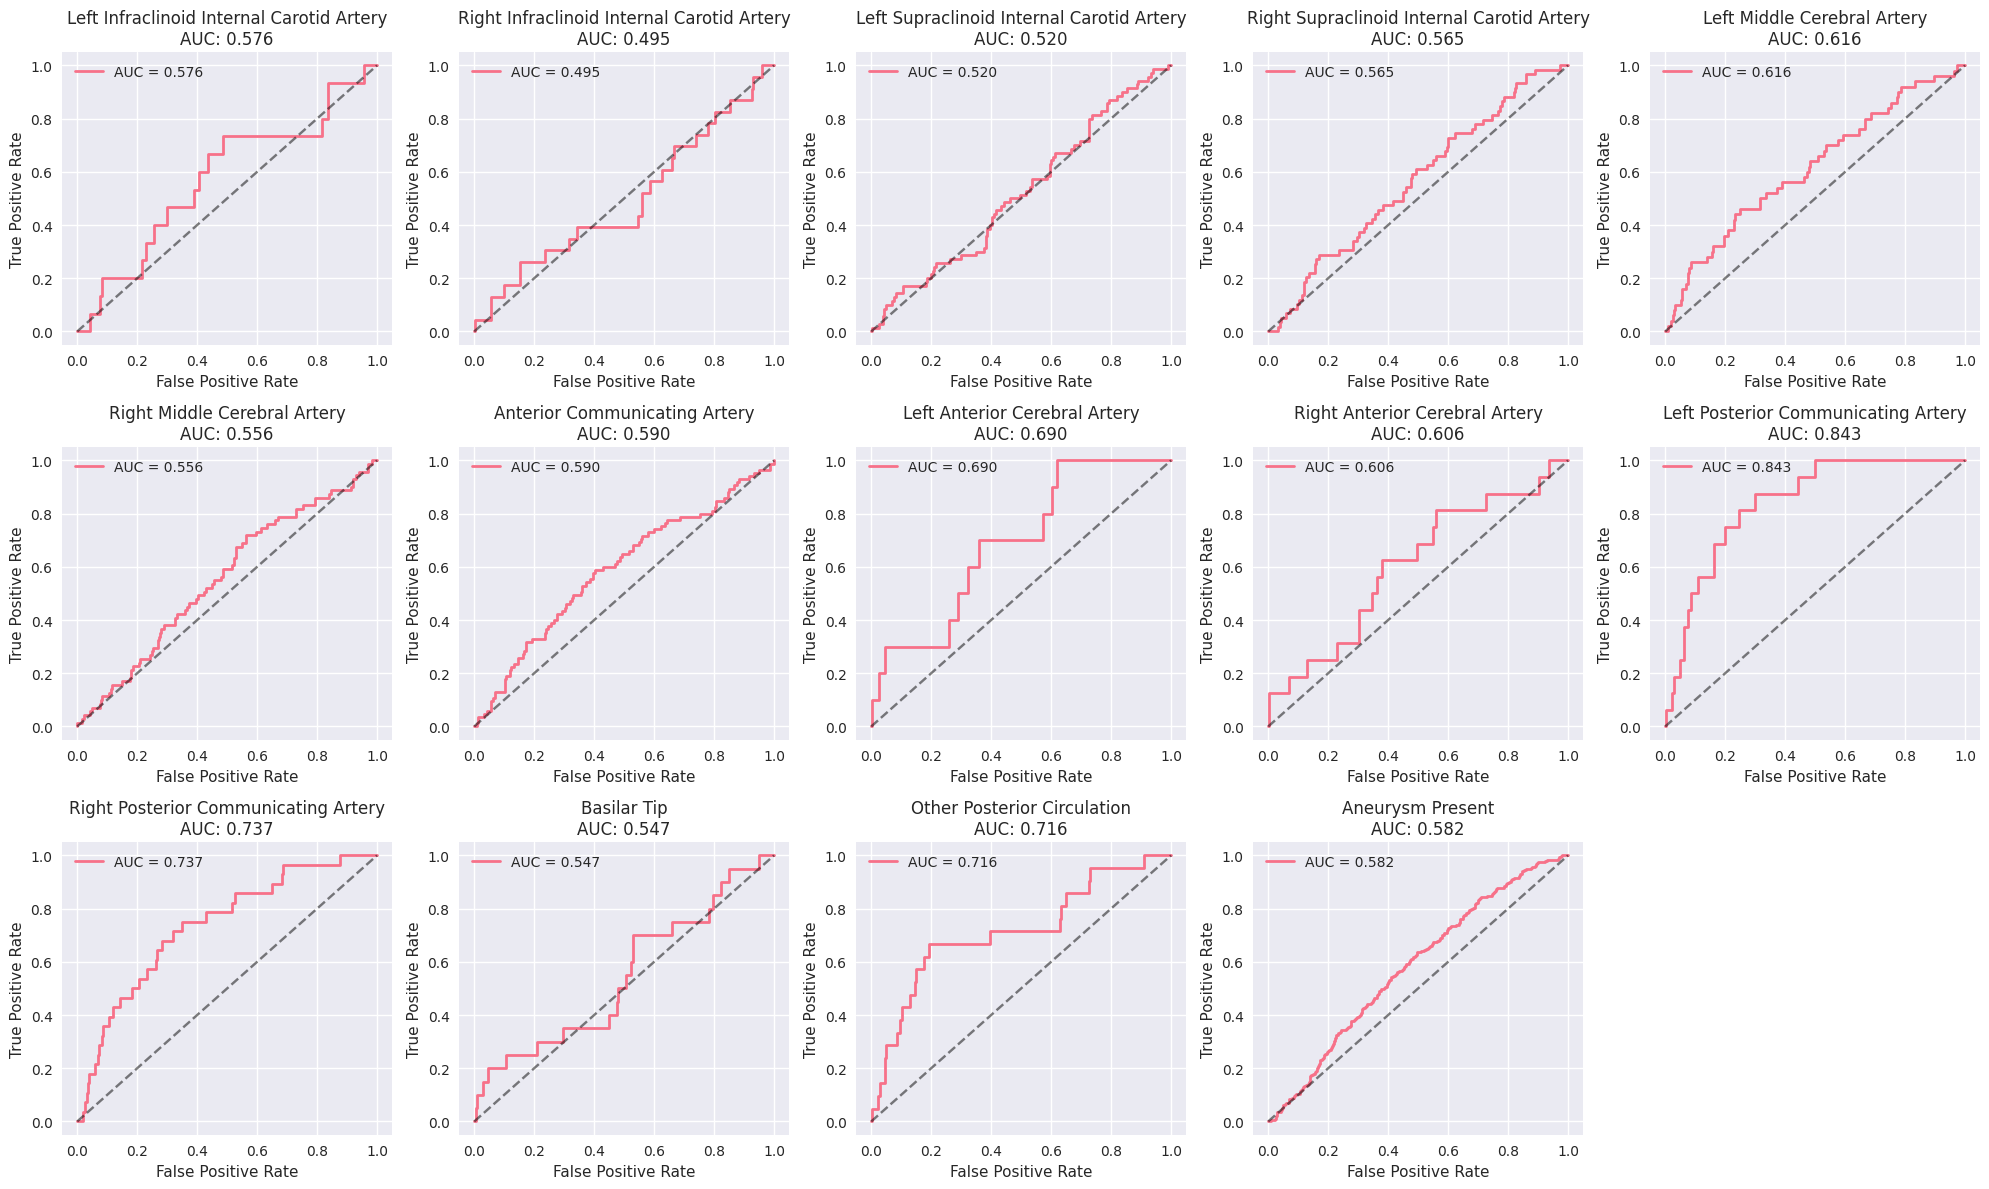

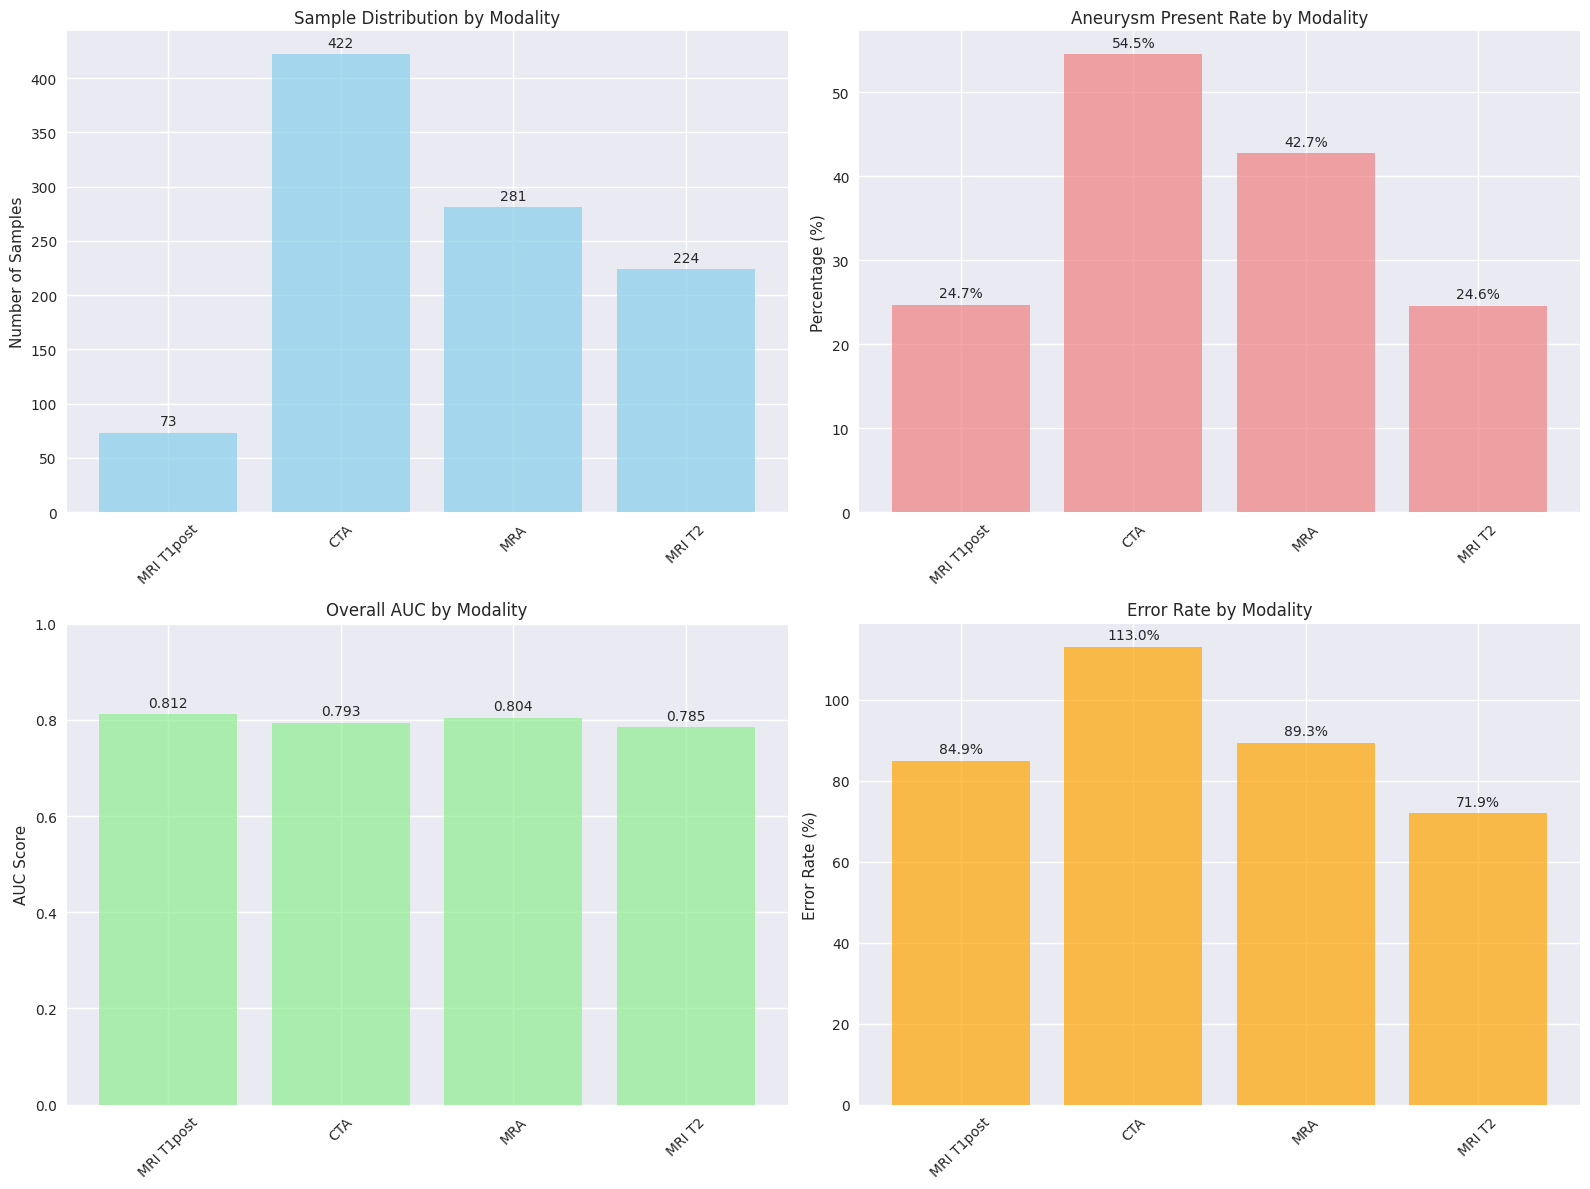

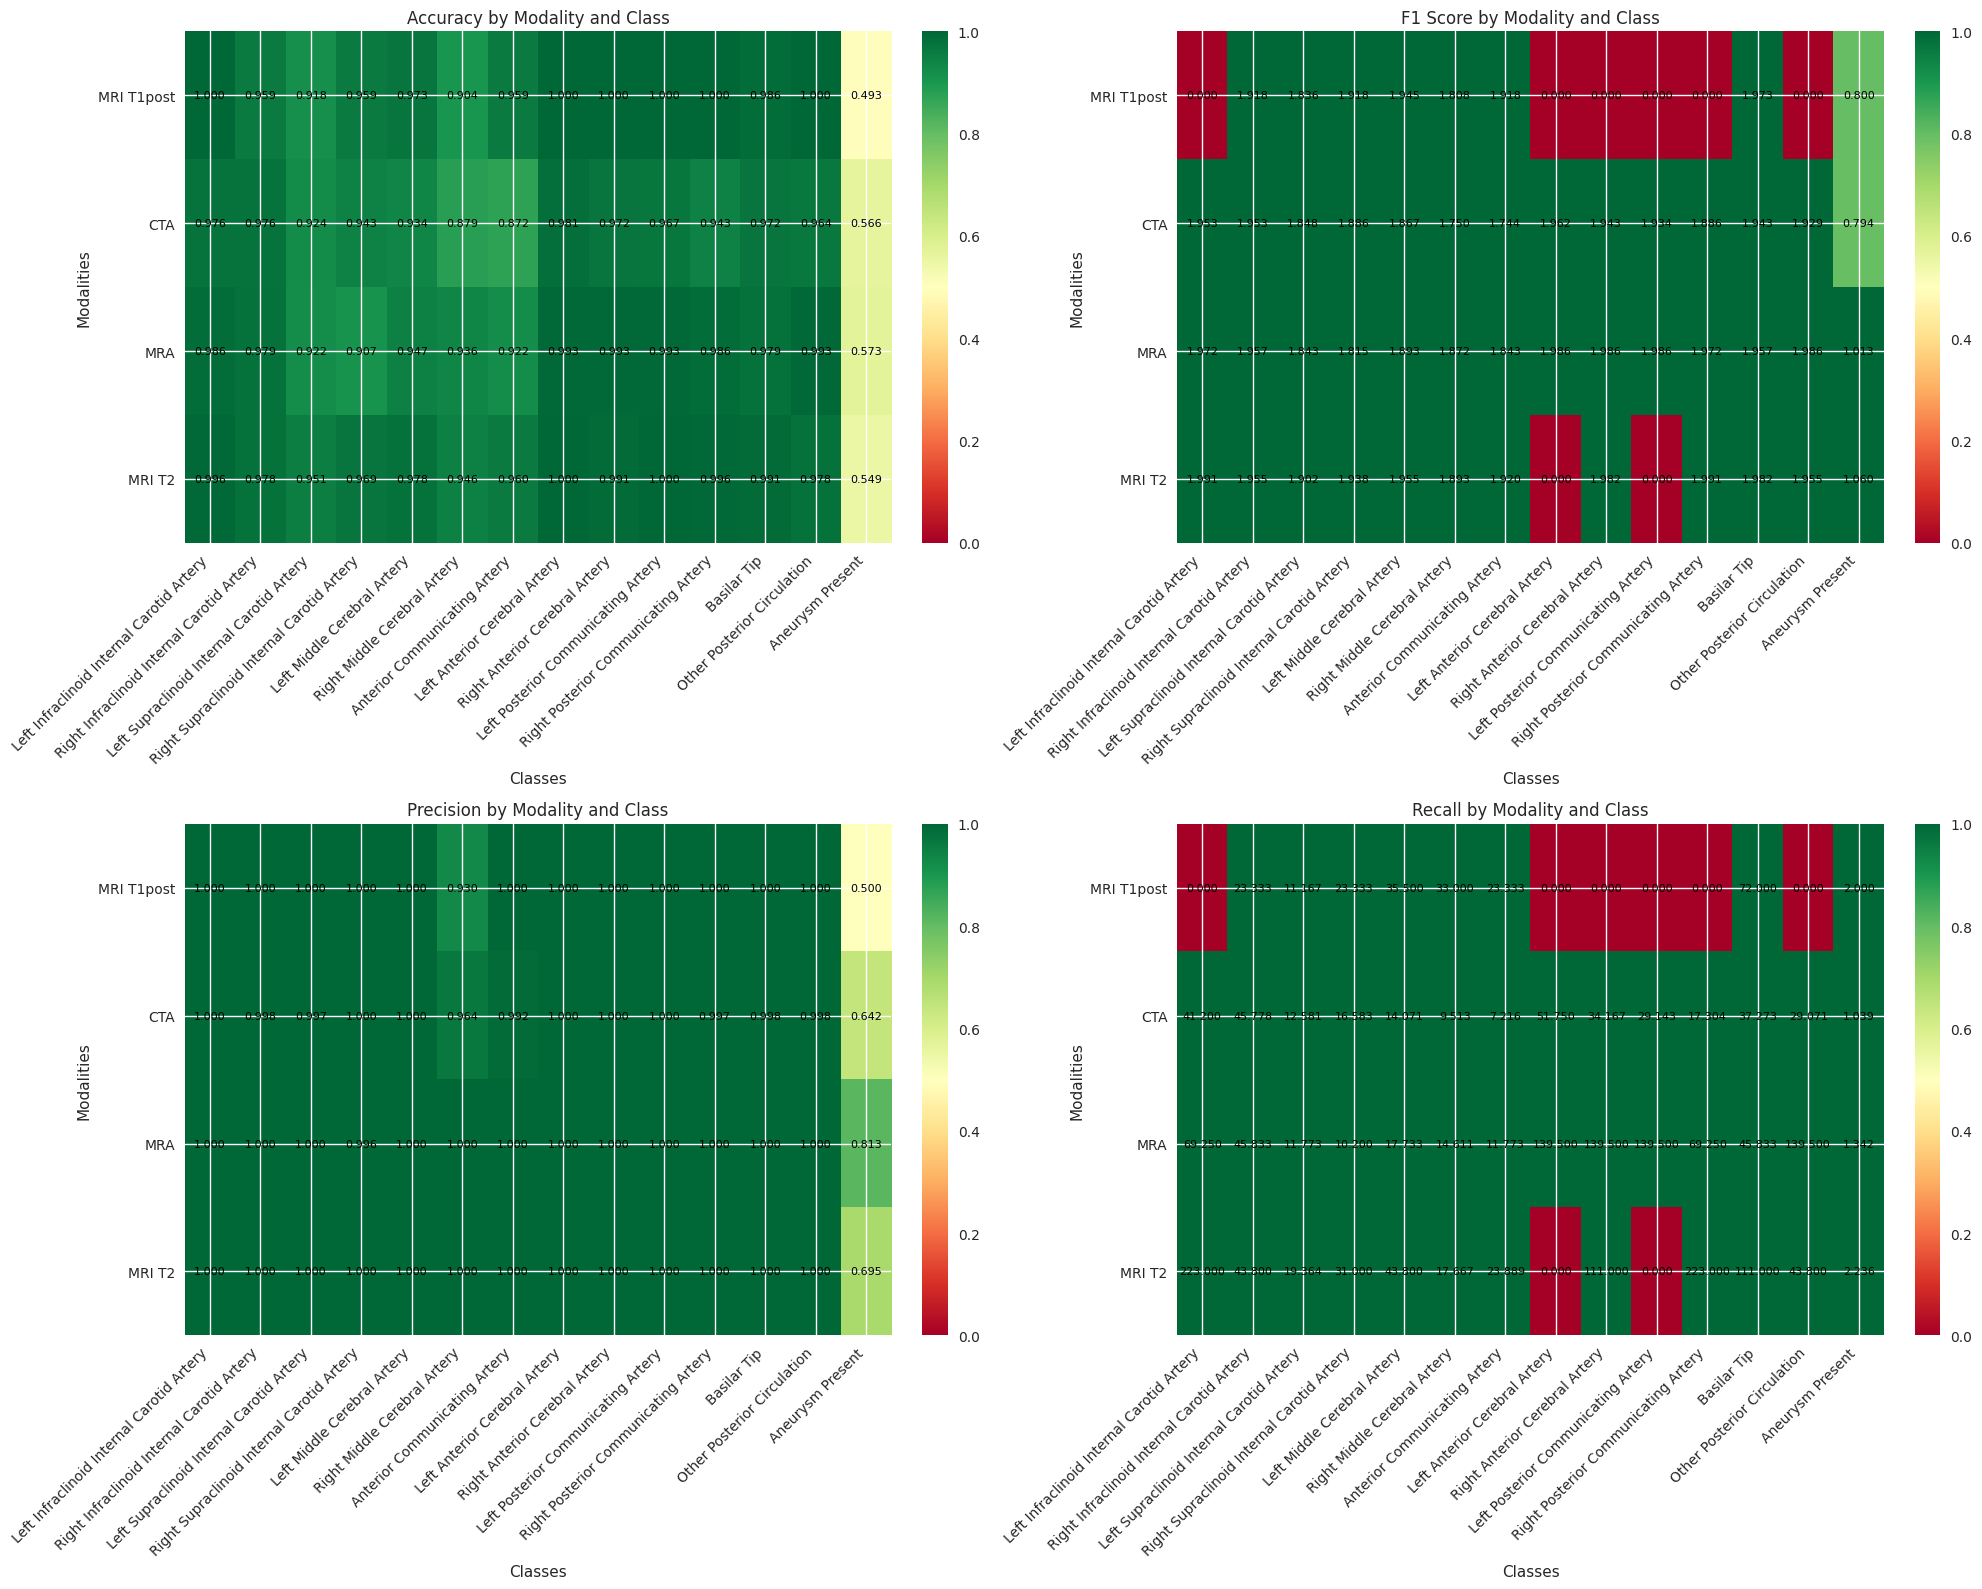

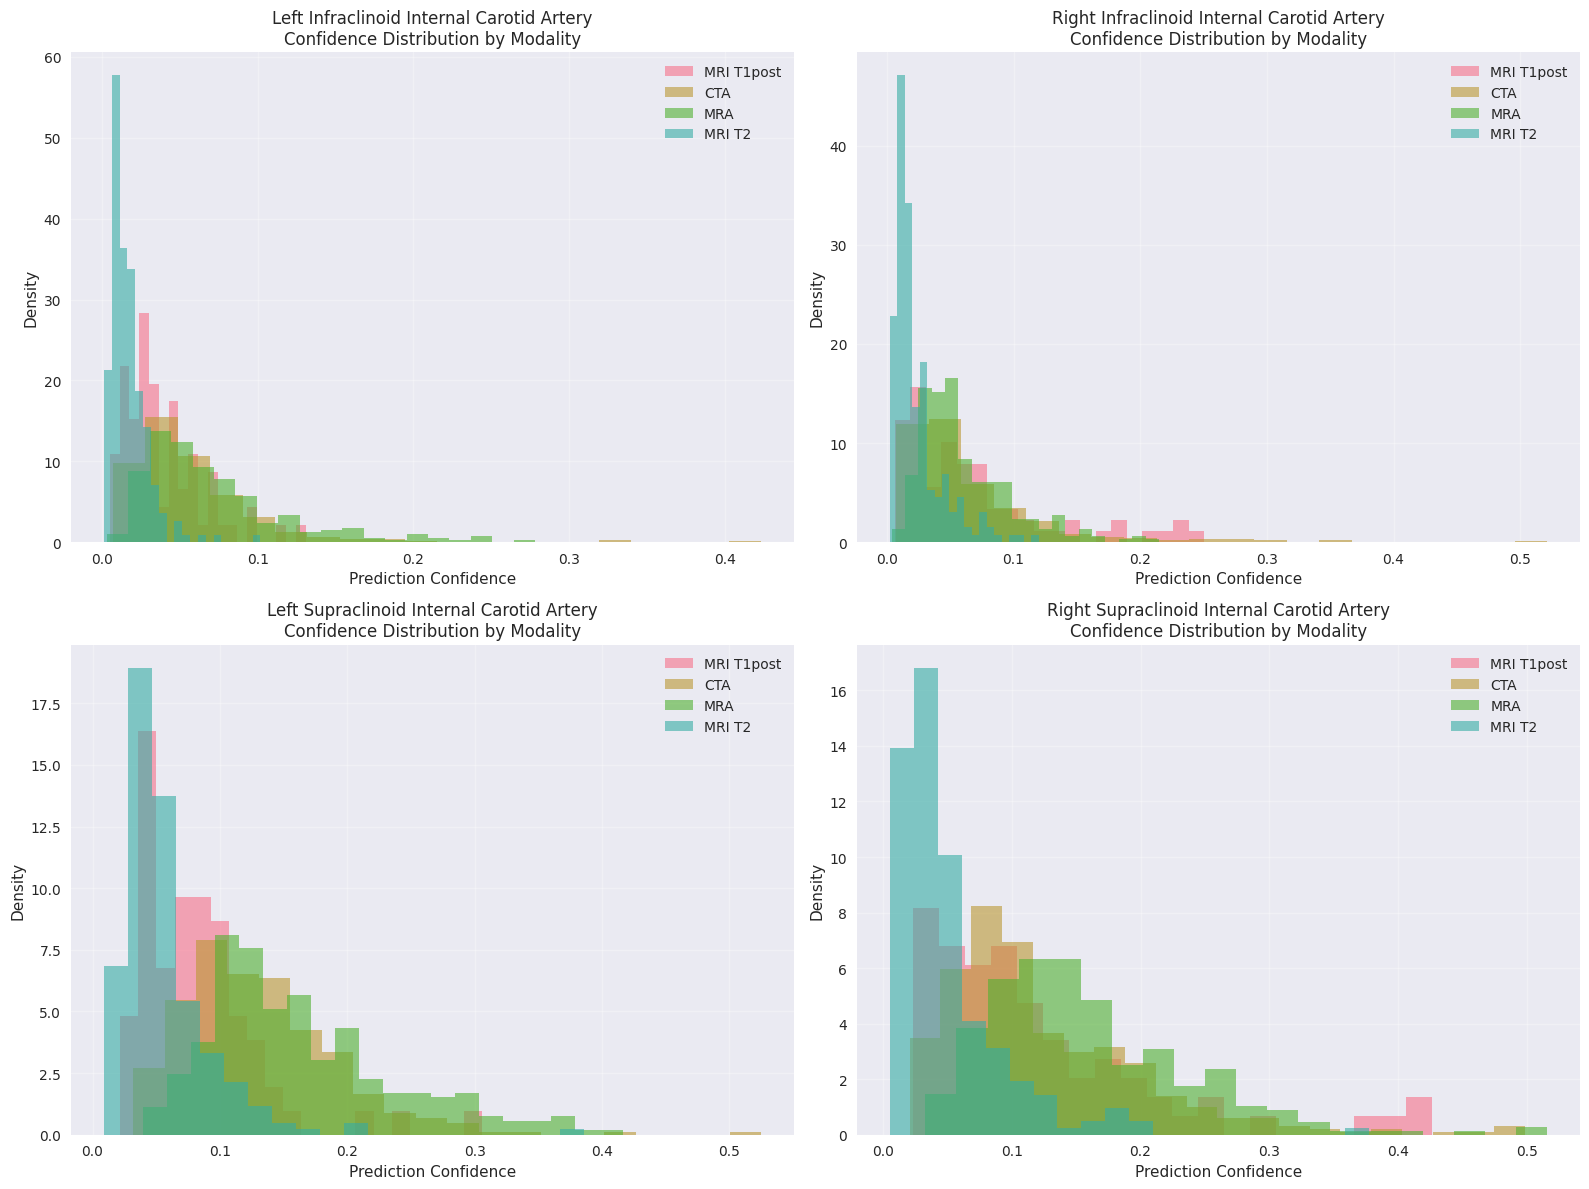

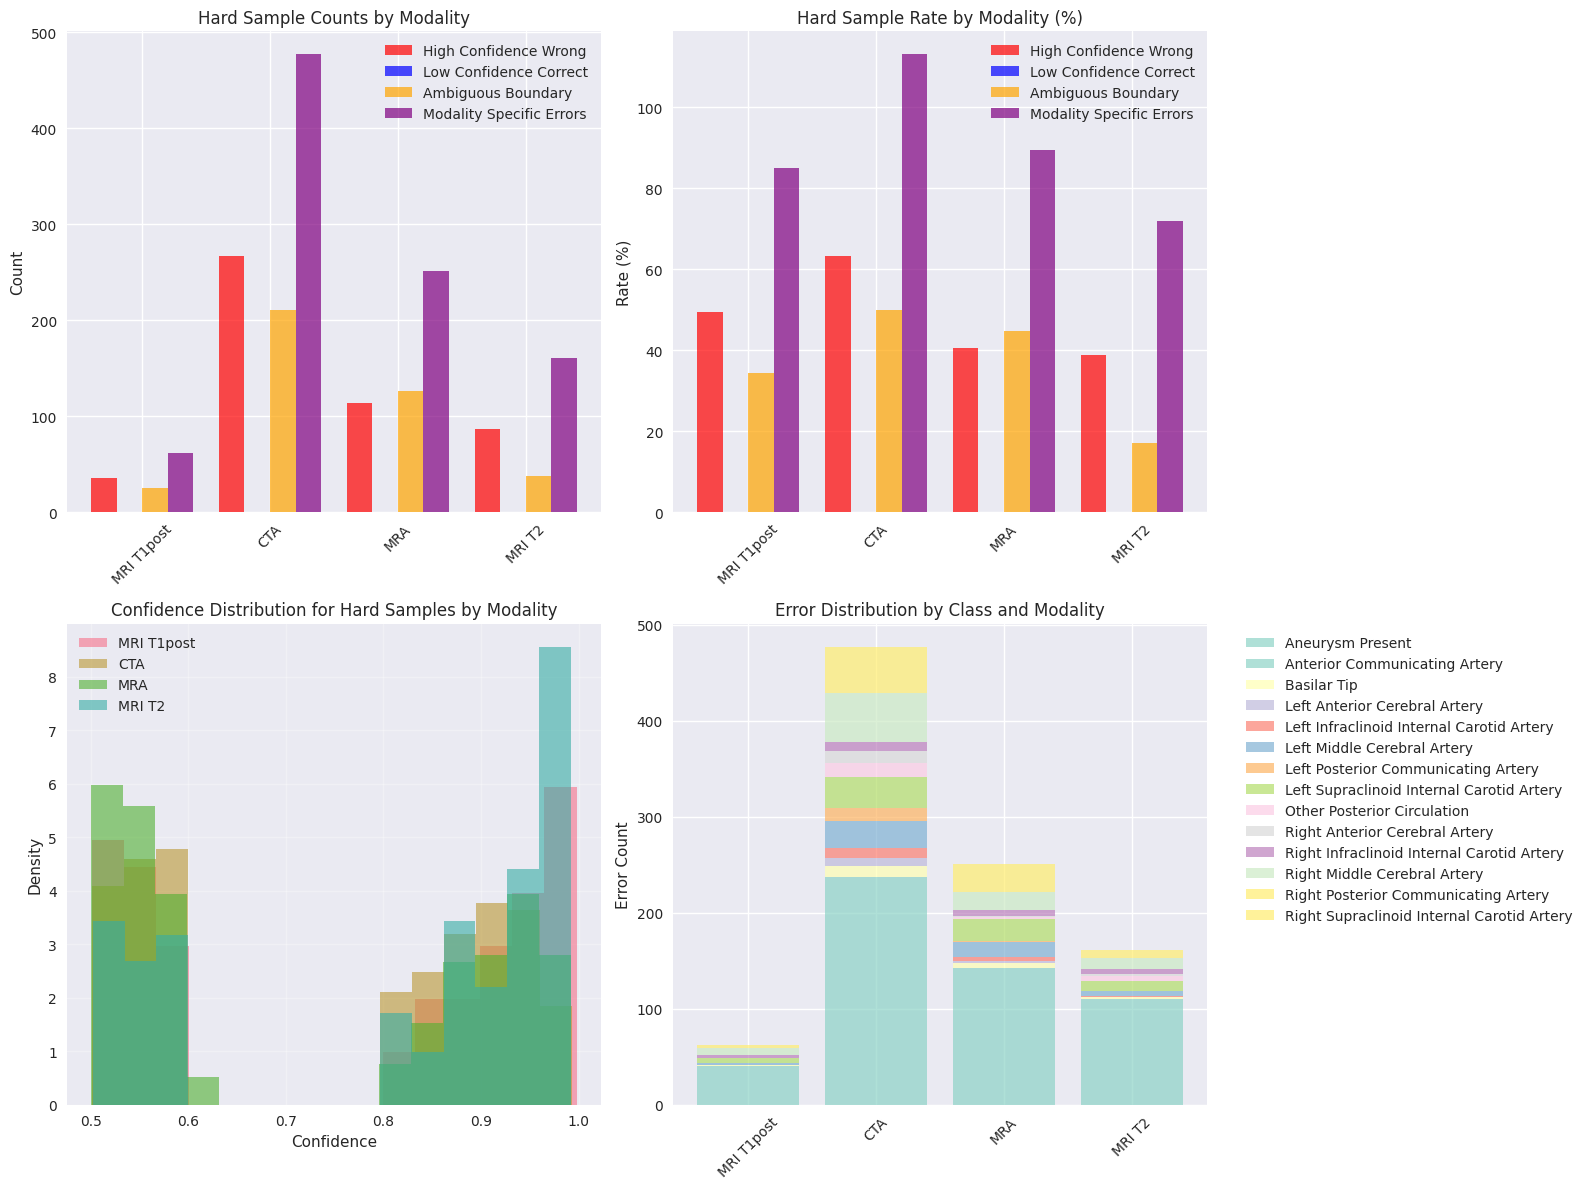

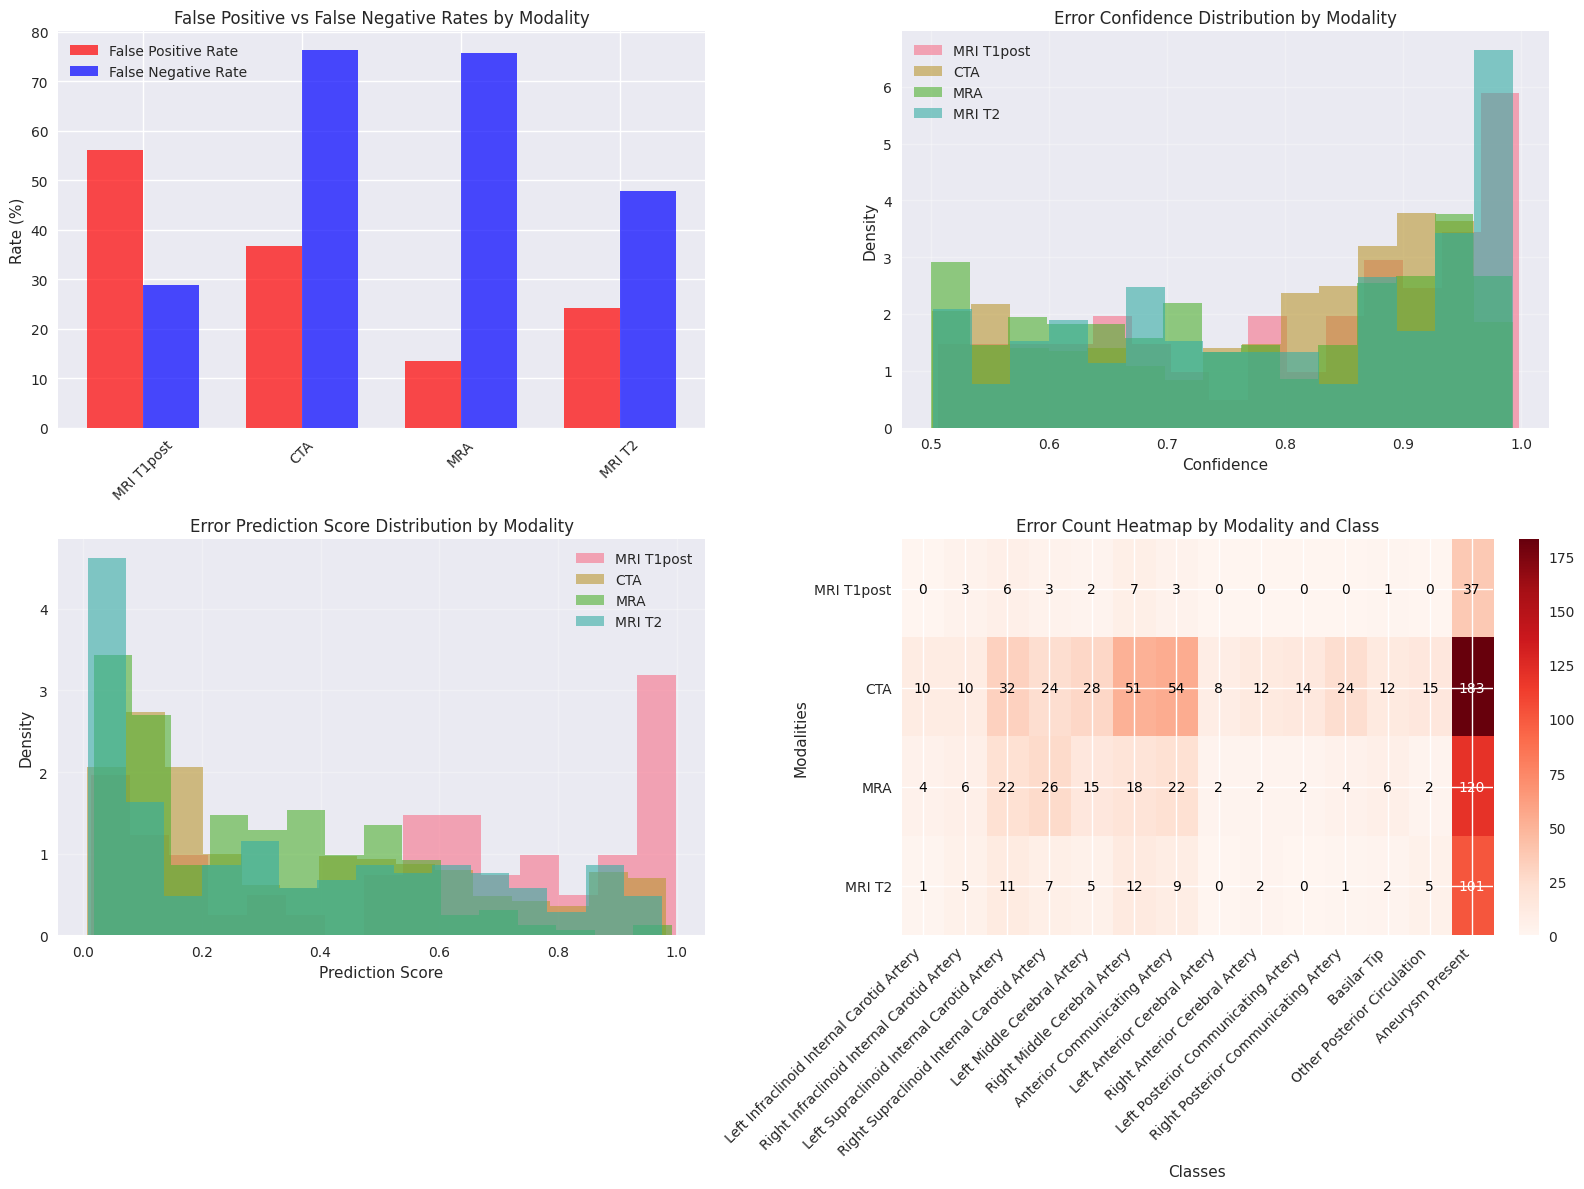

In [12]:
# Generate 4-modality visualizations
print("📈 Creating 4-modality visualizations...")
visualization_engine.create_visualizations(
    per_class_analysis=per_class_analysis,
    hard_samples=hard_samples,
    true_labels_df=true_labels_df,
    modality_analysis=modality_analysis,
    modality_hard_samples=modality_hard_samples,
    sample_modalities=modality_mapping
)
